In [ ]:
!pip install -U git+https://github.com/UN-GCPDS/python-gcpds.filters.git
!pip install -U git+https://github.com/UN-GCPDS/python-gcpds.utils.git
!pip install mne
!pip install bctpy

  Cloning https://github.com/UN-GCPDS/python-gcpds.filters.git to /tmp/pip-req-build-kreaqzzm
  Running command git clone -q https://github.com/UN-GCPDS/python-gcpds.filters.git /tmp/pip-req-build-kreaqzzm
  Created wheel for gcpds-filters: filename=gcpds_filters-0.1a0-py3-none-any.whl size=817587 sha256=f931e0275628023dd7ecb2153c99f2c51da2c47f4da25fe50fa42541a3678e4f
  Stored in directory: /tmp/pip-ephem-wheel-cache-b4t2ua16/wheels/36/7a/78/d27d0f0c7be2222e2c76dcafd6840212fbc620d24f8a7c13f0
Successfully built gcpds-filters
  Cloning https://github.com/UN-GCPDS/python-gcpds.utils.git to /tmp/pip-req-build-htm3q0pf
  Running command git clone -q https://github.com/UN-GCPDS/python-gcpds.utils.git /tmp/pip-req-build-htm3q0pf
     |████████████████████████████████| 6.9 MB 5.0 MB/s 
  Created wheel for gcpds-utils: filename=gcpds_utils-0.1a3-py3-none-any.whl size=116898 sha256=f34f705f0987e3a239c22c119aad9c3cd67a5172fc350431fdbd10696af45540
  Stored in directory: /tmp/pip-ephem-wheel-cache-

In [ ]:
from scipy.spatial.distance import squareform
import mne
from mne.connectivity import spectral_connectivity as connectivity
# drive y datos
from google.colab import drive
import requests
# estructuras
import pandas as pd
# 
from ipywidgets import interact_manual
from ipywidgets import interact
# módulo para entrenamiento
from sklearn.pipeline import Pipeline
from sklearn.model_selection import StratifiedShuffleSplit, GridSearchCV
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import make_scorer
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
# system
import os
from time import time
# data
import pickle
import numpy as np
from numpy import angle, sin, cos, sqrt
from scipy.io import loadmat, savemat
import scipy as sp
from scipy.io import savemat
from scipy.signal import butter, lfilter, welch, hanning, filtfilt, hilbert
# figuras
import matplotlib.pyplot as plt
from gcpds.utils import loaddb
from gcpds.utils.visualizations import plot_eeg, plot_topoplot
# MNE toolbox
import mne
import bct
from mne.preprocessing import ICA
# módulo de multiproceso de las tareas.
import multiprocessing

In [ ]:
# Sujetos de la base de datos
Subjects = list(np.arange(1,32))
# canales de la base de datos
channels = ['Fp1', 'Fp2', 'F7', 'F3', 'Fz', 'F4', 'F8', 'T3', 'C3', 'Cz', 'C4',
            'T4', 'T5', 'P3', 'Pz', 'P4', 'T6', 'O1', 'O2']
n_channels = len(channels)
# Frecuencia de muestreo de la base de datos.
sampling_freq  = 1000        
# ubicación de la base de datos.
load_path = '/content/drive/Shareddrives/GCPDS/databases/Databases_musica/Affective music listening 2/'
# Método utilizado para la función de ICA de MNE.
method = 'fastica'
# Número de núcleos para ell multiproceso
# pool = multiprocessing.Pool(processes=multiprocessing.cpu_count())
# ciclo de los sujetos.
y = list()
data_ref_ica = list()
data_ref = list()
for s in Subjects:
  # carga de la información del sujetos.
  S_ERP = loadmat(load_path + f"Sujeto_"+str(s)+".mat")
  print('sujeto: ', s)
  data = S_ERP['music']
  # data = np.transpose(data, (2,1,0)) # transponer en trials x canales x tiempo
  data_target = data

  # structure mne datos en (trials,canales,tiempo)
  ch_types = ['eeg']*n_channels
  info = mne.create_info(channels, ch_types=ch_types, sfreq=sampling_freq)
  info.set_montage('standard_1005')
  raw = mne.EpochsArray(data_target, info)

  # filtro la señal de 0.5 - 50 Hz.
  raw.filter(0.5,100)

  # señal sin quitar los artefactos.
  plt.figure(figsize=(20,8))
  plot_eeg(raw.get_data()[0,:,:],channels,sampling_freq)

  # Repairing artifacts with ICA
  
  ica = ICA(n_components=n_channels, method=method, max_iter='auto', random_state=0)
  ica.fit(raw)
  # componentes = ica.get_sources(raw).get_data()
  ica.plot_sources(raw, show_scrollbars=False)
  
  # señal sin quitar los artefactos.
  # plt.figure(figsize=(20,8))
  # plot_eeg(componentes[0,:,:],channels,sampling_freq)
  
  # Parametros para el análisis de la entropia.
  # tau     = 10              # 20   30 
  # window  = 1*sampling_freq # 3,   3   segundo de la ventana.
  # step    = window*0.5      # 50%, 80% de traslape.
  # windows = list(np.arange(0,componentes.shape[2]-window,step))

  # start_time = time.time()
  # entropy_tr = list()
  # for tr in range(data_target.shape[0]):
  #   data = list()
  #   for time_ in range(len(windows)):
  #     signal = np.squeeze(raw.get_data()[tr,:,int(windows[time_]):int(windows[time_]+window)])
  #     data.append(signal)
  #   # estimación de la entropía de la señal.
  #   entropy_tr.append(np.asarray(pool.map(fun_entropy, data)))
  # entropy_raw = np.asarray(entropy_tr)
  # print('Tiempo de la entropia de componentes {tim}'.format(tim=(time.time()-start_time)))
  # # ica.plot_sources(mne.io.RawArray(raw.get_data()[0], info))
  
  # start_time = time.time()
  # entropy_tr = list()
  # for tr in range(data_target.shape[0]):
  #   data = list()
  #   for time_ in range(len(windows)):
  #     signal = np.squeeze(componentes[tr,:,int(windows[time_]):int(windows[time_]+window)])
  #     data.append(signal)
  #   # estimación de la entropía de las componentes.
  #   entropy_tr.append(np.asarray(pool.map(fun_entropy, data)))
  # entropy_com = np.asarray(entropy_tr)
  # print('Tiempo de la entropia de componentes {tim}'.format(tim=(time.time()-start_time)))
  
  raw2 = raw.copy()
  # comp_ = []
  # for tr in range(entropy_com.shape[0]):
  #   datos_ = np.max(entropy_com[tr,:,:],axis=0)-np.min(entropy_com[0,:,:],axis=0)
  #   datos_f = np.asarray([round(a,1) for a in datos_])
  #   comp_.append(np.where((datos_f>0)==True)[0])
  # pos = list(np.unique(np.concatenate(comp_)))
  ica.exclude = [0]          # indices chosen based on various plots above sujeto 2.
  ica.apply(raw2)
  
  # # figura señal quitando artefactos
  plt.figure(figsize=(20,8))
  plot_eeg(raw2.get_data()[0,:,:],channels,sampling_freq)

  # start_time = time.time()
  # entropy_tr = list()
  # for tr in range(data_target.shape[0]):
  #   data = list()
  #   for time_ in range(len(windows)):
  #     signal = np.squeeze(raw2.get_data()[tr,:,int(windows[time_]):int(windows[time_]+window)])
  #     data.append(signal)
  #   # estimación de la entropía de la señal quitando artefactos.
  #   entropy_tr.append(np.asarray(pool.map(fun_entropy, data)))
  # entropy_ica = np.asarray(entropy_tr)
  # print('Tiempo de la entropia de la señal {tim}'.format(tim=(time.time()-start_time)))

  # # CAR common average reference
  # # En la señal.
  rereferenced_raw, ref_data = mne.set_eeg_reference(raw, ref_channels='average',projection=True,verbose=0)
  data_ref.append(rereferenced_raw.get_data())
  # data_ref = rereferenced_raw.get_data()
  # # En la señal reconstruida.
  rereferenced_raw_ica, ref_data = mne.set_eeg_reference(raw2, ref_channels='average',projection=True,verbose=0)
  data_ref_ica.append(rereferenced_raw.get_data())
  # data_ref_ica = rereferenced_raw_ica.get_data()
  # savemat(load_path+f'Resultado_music_Sujeto'+str(s)+'.mat',{'X_ica':raw2.get_data(),'X_raw':raw.get_data(),'ref_raw':data_ref,
  #           'ref_ica':data_ref_ica,'H_raw':entropy_raw,'H_com':entropy_com,'H_ica':entropy_ica})

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
est = loadmat('/content/esti.mat')
esti = est['esti']
y_km_t_3 = loadmat('/content/y_km.mat')['y_km_t_3']
y_km_f_3 = loadmat('/content/y_km.mat')['y_km_f_3']
y_km_e_3 = loadmat('/content/y_mt.mat')['y_km_e_3']

In [ ]:
# # organizar datos según clases seleccionadas
# data_org_gr = list()
# pos_t2 = np.concatenate(np.asarray(list(y_km_t_3)).reshape(-1,1)[esti[0,:].astype(bool)])
# for gr in range(3):
#   data_org_ = list()
#   for sub in Subjects: 
#     data_org_.append(data_ref[sub-1][pos_t2==gr,:,:])
#   data_org_gr.append(data_org_)

# conectividad con eeg filtrado y referenciado con promedio común

In [ ]:
# Sujetos de la base de datos
Subjects = list(np.arange(1,32))
# canales de la base de datos
channels = ['Fp1', 'Fp2', 'F7', 'F3', 'Fz', 'F4', 'F8', 'T3', 'C3', 'Cz', 'C4',
            'T4', 'T5', 'P3', 'Pz', 'P4', 'T6', 'O1', 'O2']
n_channels = len(channels)
# Frecuencia de muestreo de la base de datos.
sampling_freq  = 1000        
# ubicación de la base de datos.
load_path = '/content/drive/Shareddrives/GCPDS/databases/Databases_musica/Affective music listening 2/'

# Prueba de grupo
fmin = 1
fmax = 45
tmin = 0#2*sampling_freq
tmax = 15*sampling_freq
window  = 1*sampling_freq # 3,   3   segundo de la ventana.
step    = window*1      # 50%, 80% de traslape.
windows = list(np.arange(tmin,tmax-window,step))
cwt_freqs = np.arange(2, 47, 2)
cwt_n_cycles = cwt_freqs / 5
v = int((19*(18))/2)

In [ ]:
pos_t2 = np.concatenate(np.asarray(list(y_km_t_3)).reshape(-1,1)[esti[0,:].astype(bool)])
for gr in range(3):
  for sub in Subjects:
    con, freqs, times, n_epochs, n_tapers = connectivity(data_ref[sub-1][pos_t2==gr,:,:],
                                                         method='plv',  mode='cwt_morlet', sfreq=sampling_freq,
                                                         cwt_freqs=cwt_freqs, 
                                                         cwt_n_cycles=cwt_n_cycles, n_jobs=1,
                                                         verbose = 10)
    plv = np.zeros((v,freqs.shape[0],times.shape[0]))
    for fr in range(freqs.shape[0]):
      for t in range(times.shape[0]):
        plv[:,fr,t]= squareform(con[:,:,fr,t]+con[:,:,fr,t].T)
    del con
    savemat(load_path+f'conectividad_plv_s'+str(sub)+'_gr'+str(gr+1)+'.mat',{'PLV':plv,'freqs':freqs,'times':times,'n_epochs':n_epochs})

Connectivity computation...
only using indices for lower-triangular matrix
    computing connectivity for 171 connections
    using t=0.000s..15.000s for estimation (15001 points)
    frequencies: 2.0Hz..46.0Hz (23 points)
    using CWT with Morlet wavelets to estimate spectra
    the following metrics will be computed: PLV
    computing connectivity for epoch 1
    computing connectivity for epoch 2
    computing connectivity for epoch 3
    computing connectivity for epoch 4
    computing connectivity for epoch 5
    computing connectivity for epoch 6
    computing connectivity for epoch 7
    computing connectivity for epoch 8
    computing connectivity for epoch 9
    computing connectivity for epoch 10
    computing connectivity for epoch 11
    computing connectivity for epoch 12
    assembling connectivity matrix
[Connectivity computation done]
Connectivity computation...
only using indices for lower-triangular matrix
    computing connectivity for 171 connections
    using t=0.

# conectividad con eeg filtrado y referenciado con promedio común y quitando 1 artefacto

In [ ]:
pos_t2 = np.concatenate(np.asarray(list(y_km_t_3)).reshape(-1,1)[esti[0,:].astype(bool)])
for gr in range(3):
  for sub in Subjects:
    con, freqs, times, n_epochs, n_tapers = connectivity(data_ref_ica[sub-1][pos_t2==gr,:,:],
                                                         method='plv',  mode='cwt_morlet', sfreq=sampling_freq,
                                                         cwt_freqs=cwt_freqs, 
                                                         cwt_n_cycles=cwt_n_cycles, n_jobs=1,
                                                         verbose = 10)
    plv = np.zeros((v,freqs.shape[0],times.shape[0]))
    for fr in range(freqs.shape[0]):
      for t in range(times.shape[0]):
        plv[:,fr,t]= squareform(con[:,:,fr,t]+con[:,:,fr,t].T)
    del con
    savemat(load_path+f'conectividad_plv_ica_s'+str(sub)+'_gr'+str(gr+1)+'.mat',{'PLV':plv,'freqs':freqs,'times':times,'n_epochs':n_epochs})

Connectivity computation...
only using indices for lower-triangular matrix
    computing connectivity for 171 connections
    using t=0.000s..15.000s for estimation (15001 points)
    frequencies: 2.0Hz..46.0Hz (23 points)
    using CWT with Morlet wavelets to estimate spectra
    the following metrics will be computed: PLV
    computing connectivity for epoch 1
    computing connectivity for epoch 2
    computing connectivity for epoch 3
    computing connectivity for epoch 4
    computing connectivity for epoch 5
    computing connectivity for epoch 6
    computing connectivity for epoch 7
    computing connectivity for epoch 8
    computing connectivity for epoch 9
    computing connectivity for epoch 10
    computing connectivity for epoch 11
    computing connectivity for epoch 12
    assembling connectivity matrix
[Connectivity computation done]
Connectivity computation...
only using indices for lower-triangular matrix
    computing connectivity for 171 connections
    using t=0.

In [ ]:
bands

[2, 4, 8, 12, 16, 20, 24, 28, 32, 36, 40, 44]

In [ ]:
umbral = 0.3
# Sujetos de la base de datos
Subjects = list(np.arange(1,32))
# canales de la base de datos
channels = ['Fp1', 'Fp2', 'F7', 'F3', 'Fz', 'F4', 'F8', 'T3', 'C3', 'Cz', 'C4',
            'T4', 'T5', 'P3', 'Pz', 'P4', 'T6', 'O1', 'O2']
n_channels = len(channels)
v = int((n_channels*(n_channels-1))/2)
# Frecuencia de muestreo de la base de datos.
sampling_freq  = 1000
# ubicación de la base de datos.
load_path = '/content/drive/Shareddrives/GCPDS/databases/Databases_musica/Affective music listening 2/'

window  = 1*sampling_freq # 3,   3   segundo de la ventana.
step    = window*1      # 50%, 80% de traslape.
windows = list(np.arange(0,15*sampling_freq-window,step))
bands   = [2]
bands.extend(list(freqs[0,1::2].astype(int)))


plv_gr  = list()
for gr in range(3):
  plv   = np.zeros((len(Subjects),v,len(bands)-1,len(windows)))
  for sub in Subjects:
    print('Sujeto'+str(sub))
    data = loadmat(load_path+f'conectividad_plv_s'+str(sub)+'_gr'+str(gr+1)+'.mat')
    con_ = data['PLV']
    con = np.zeros((con_.shape[0],len(bands),con_.shape[2]))
    
    for fr in range(len(bands)-1):
      if fr == 0:
        fr1,fr2 = fr,fr+1
      else: 
        fr1,fr2 = list(freqs[0,:]).index(bands[fr]),list(freqs[0,:]).index(bands[fr+1])
      con[:,fr,:] = np.mean(con_[:,fr1:fr2,:],axis=1)
      
    freqs = data['freqs']
    times = data['times']
    for fr in range(len(bands)-1):
      for t in range(len(windows)):
        plv[sub-1,:,fr,t] = squareform(bct.threshold_proportional(squareform((np.squeeze(con[:,fr,int(windows[t])]))),umbral))
    del con
  plv_gr.append(plv)


Sujeto1
Sujeto2
Sujeto3
Sujeto4
Sujeto5
Sujeto6
Sujeto7
Sujeto8
Sujeto9
Sujeto10
Sujeto11
Sujeto12
Sujeto13
Sujeto14
Sujeto15
Sujeto16
Sujeto17
Sujeto18
Sujeto19
Sujeto20
Sujeto21
Sujeto22
Sujeto23
Sujeto24
Sujeto25
Sujeto26
Sujeto27
Sujeto28
Sujeto29
Sujeto30
Sujeto31
Sujeto1
Sujeto2
Sujeto3
Sujeto4
Sujeto5
Sujeto6
Sujeto7
Sujeto8
Sujeto9
Sujeto10
Sujeto11
Sujeto12
Sujeto13
Sujeto14
Sujeto15
Sujeto16
Sujeto17
Sujeto18
Sujeto19
Sujeto20
Sujeto21
Sujeto22
Sujeto23
Sujeto24
Sujeto25
Sujeto26
Sujeto27
Sujeto28
Sujeto29
Sujeto30
Sujeto31
Sujeto1
Sujeto2
Sujeto3
Sujeto4
Sujeto5
Sujeto6
Sujeto7
Sujeto8
Sujeto9
Sujeto10
Sujeto11
Sujeto12
Sujeto13
Sujeto14
Sujeto15
Sujeto16
Sujeto17
Sujeto18
Sujeto19
Sujeto20
Sujeto21
Sujeto22
Sujeto23
Sujeto24
Sujeto25
Sujeto26
Sujeto27
Sujeto28
Sujeto29
Sujeto30
Sujeto31


In [ ]:
data = loadmat(load_path+f'conectividad_plv_s'+str(1)+'_gr'+str(1)+'.mat')
   
freqs = data['freqs']
times = data['times']

In [ ]:
plv_gr=loadmat('plv_gr.mat')['plv_gr']

# promedio de los sujetos

In [ ]:
montage='standard_1020'
info = mne.create_info(channels, sfreq=sampling_freq, ch_types="eeg")
info.set_montage(montage)
layout=mne.channels.find_layout(info,ch_type='eeg') 
layout

<Layout | EEG - Channels: Fp1, Fp2, F7 ...>

In [ ]:
layout.pos.shape
pos = np.array([(p[0] + p[2] / 2., p[1] + p[3] / 2.) for p in layout.pos])

In [ ]:
import bct

Grupo 1

In [ ]:
for gr in range(1):
  plv_ = np.squeeze(np.mean(plv_gr[gr],axis=0)) # plv es de sujetos,conexiones,frecuencias y tiempos.
  itr = 1
  fig=plt.figure(figsize=(30,30))
  for fre in range(len(bands)-1):#Subjects:
    for t in range(plv_.shape[2]):
      ax = fig.add_subplot(len(bands)-1,plv_.shape[2],itr)
      itr +=1
      mne.viz.plot_topomap(bct.strengths_und(squareform(plv_[:,fre,t])),
                          info, axes=ax, cmap='viridis', show=False, #sensors=True,
                          extrapolate='head', ch_type='eeg')
      

Output hidden; open in https://colab.research.google.com to view.

grupo 2

In [ ]:
plv_gr[0].shape

(31, 171, 11, 14)

In [ ]:
for gr in range(1,2):
  plv_ = np.squeeze(np.mean(plv_gr[gr],axis=0)) # plv es de sujetos,conexiones,frecuencias y tiempos.
  itr = 1
  fig=plt.figure(figsize=(30,30))
  for fre in range(len(bands)-1):#Subjects:
    for t in range(plv_.shape[2]):
      ax = fig.add_subplot(len(bands)-1,plv_.shape[2],itr)
      itr +=1
      mne.viz.plot_topomap(bct.strengths_und(squareform(plv_[:,fre,t])),
                          info, axes=ax, cmap='viridis', show=False, #sensors=True,
                          extrapolate='head', ch_type='eeg')
      

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
for gr in range(2,3):
  plv_ = np.squeeze(np.mean(plv_gr[gr],axis=0)) # plv es de sujetos,conexiones,frecuencias y tiempos.
  itr = 1
  fig=plt.figure(figsize=(30,30))
  for fre in range(len(bands)-1):#Subjects:
    for t in range(plv_.shape[2]):
      ax = fig.add_subplot(len(bands)-1,plv_.shape[2],itr)
      itr +=1
      mne.viz.plot_topomap(bct.strengths_und(squareform(plv_[:,fre,t])),
                          info, axes=ax, cmap='viridis', show=False, #sensors=True,
                          extrapolate='head', ch_type='eeg')
      

Output hidden; open in https://colab.research.google.com to view.

# Metodo de selección OR y AND

## AND

In [ ]:
plv_.shape

(31, 171, 11, 14)

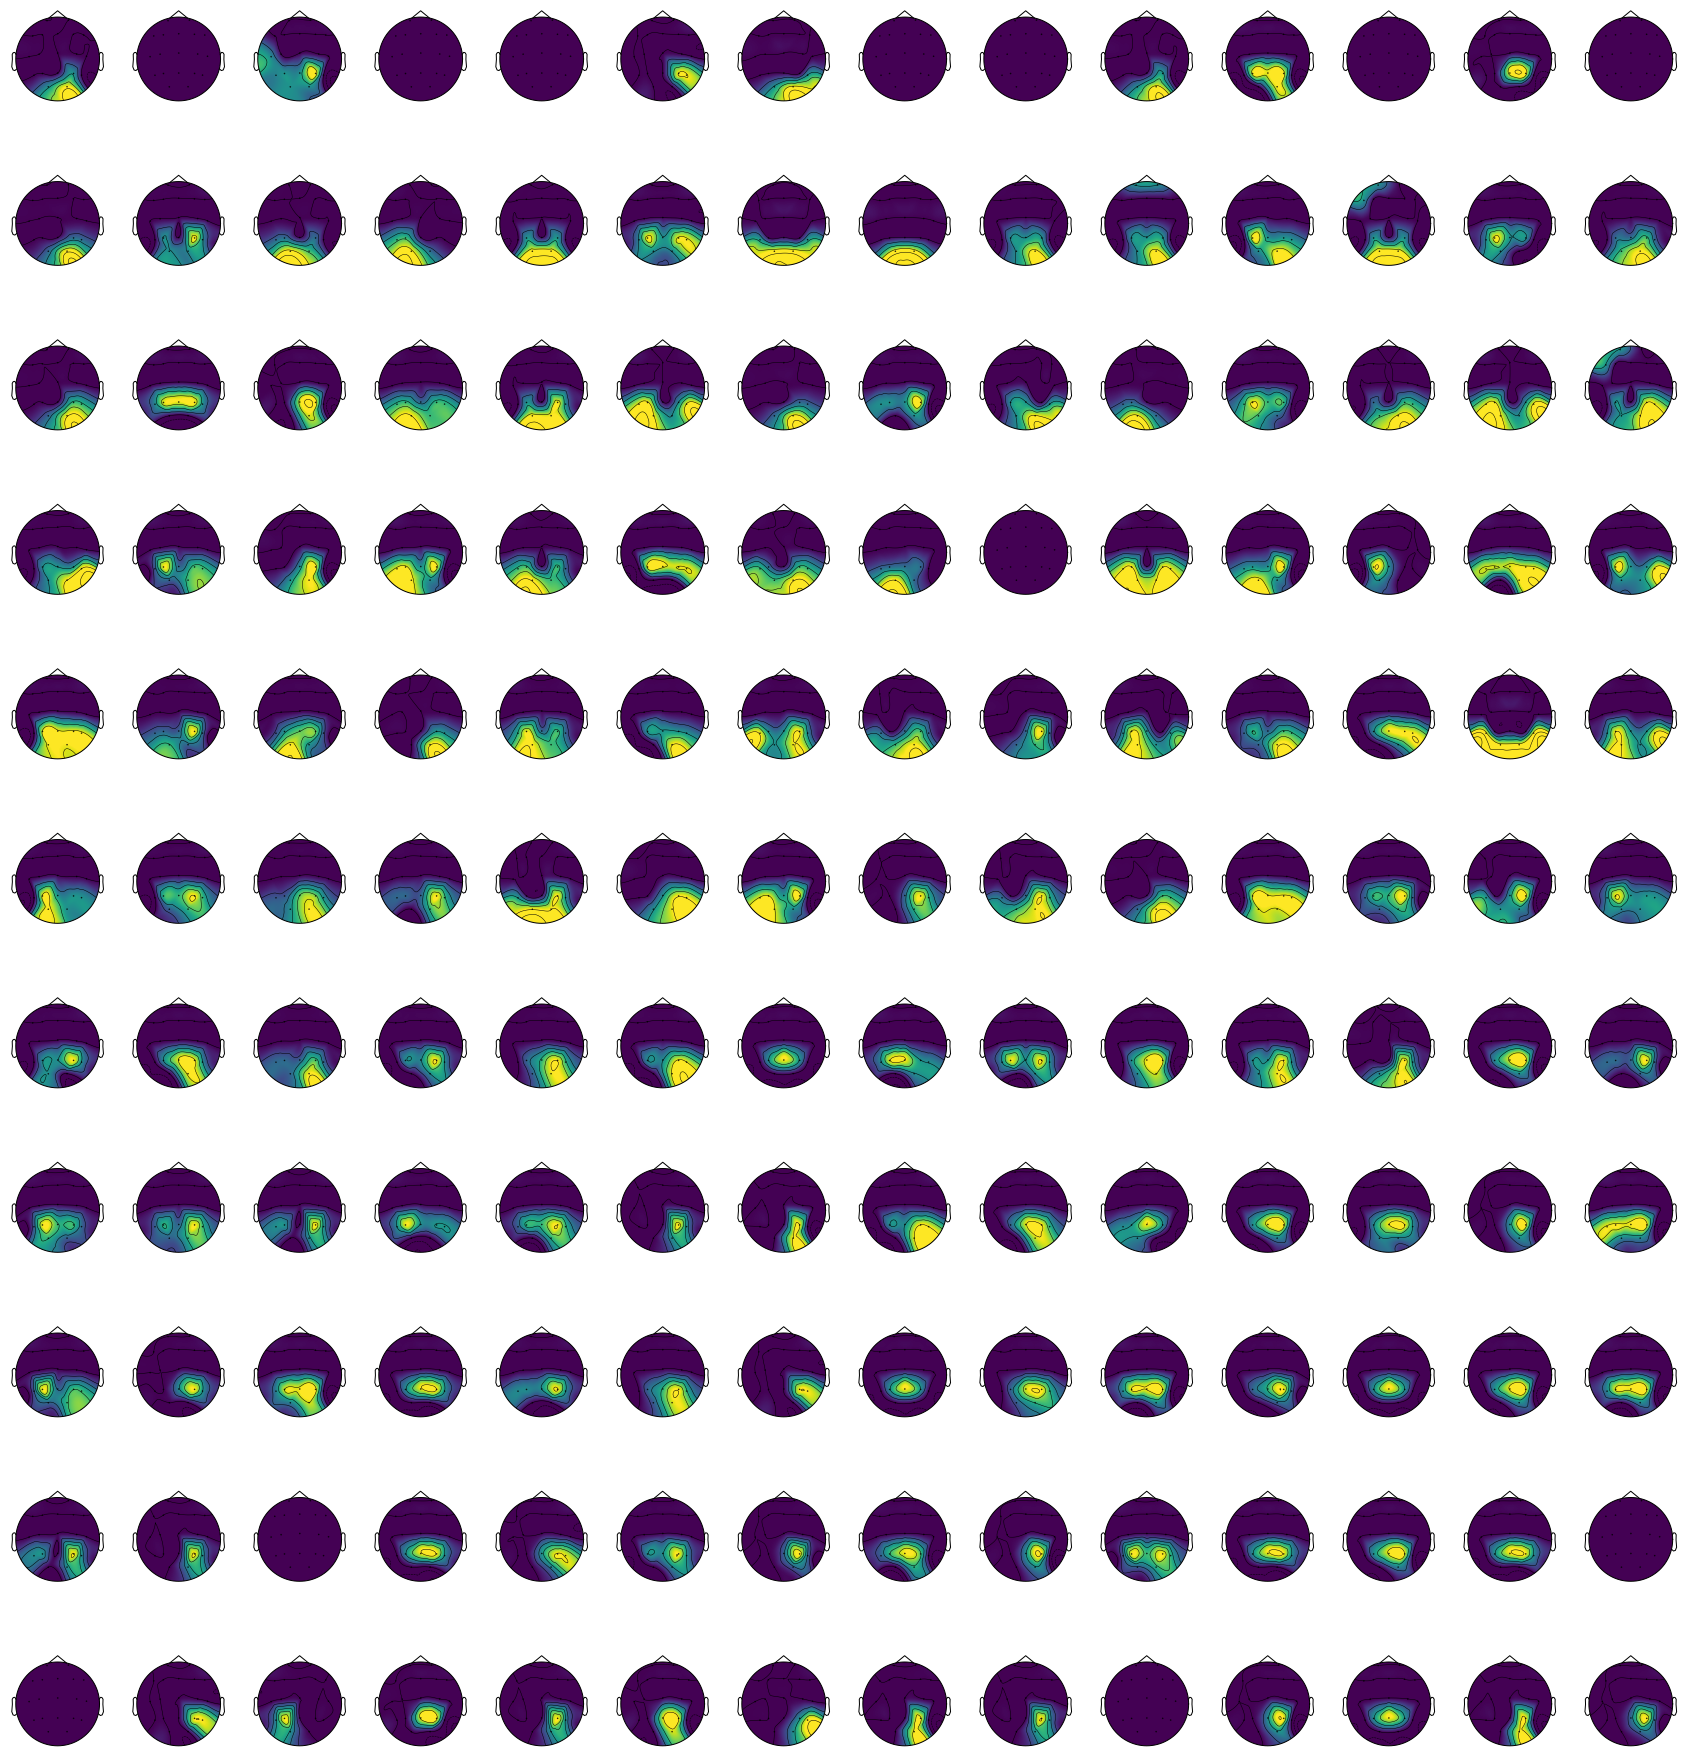

In [ ]:
for gr in range(1):
  plv = plv_gr[gr]
  plv_m = np.zeros((plv.shape[0],plv.shape[1],plv.shape[2],plv.shape[3]))
  for fre in range(plv.shape[2]):#Subjects:
    for t in range(len(windows)):
      for cx in range(plv.shape[1]):
        if sum(plv[:,cx,fre,t]>0) == len(Subjects):
          plv_m[:,cx,fre,t] = plv[:,cx,fre,t].dot(1)
        else:
          plv_m[:,cx,fre,t] = plv[:,cx,fre,t].dot(0)

  plv_ = np.squeeze(np.mean(plv_m,axis=0)) # plv es de sujetos,conexiones,frecuencias y tiempos.

  itr = 1
  fig=plt.figure(figsize=(30,30))
  for fre in range(len(bands)-1):#Subjects:
    for t in range(plv_.shape[2]):
      ax = fig.add_subplot(len(bands)-1,plv_.shape[2],itr)
      itr +=1
      mne.viz.plot_topomap(bct.strengths_und(squareform(plv_[:,fre,t])),
                          info, axes=ax, cmap='viridis', show=False, #sensors=True,
                          extrapolate='head', ch_type='eeg')
      

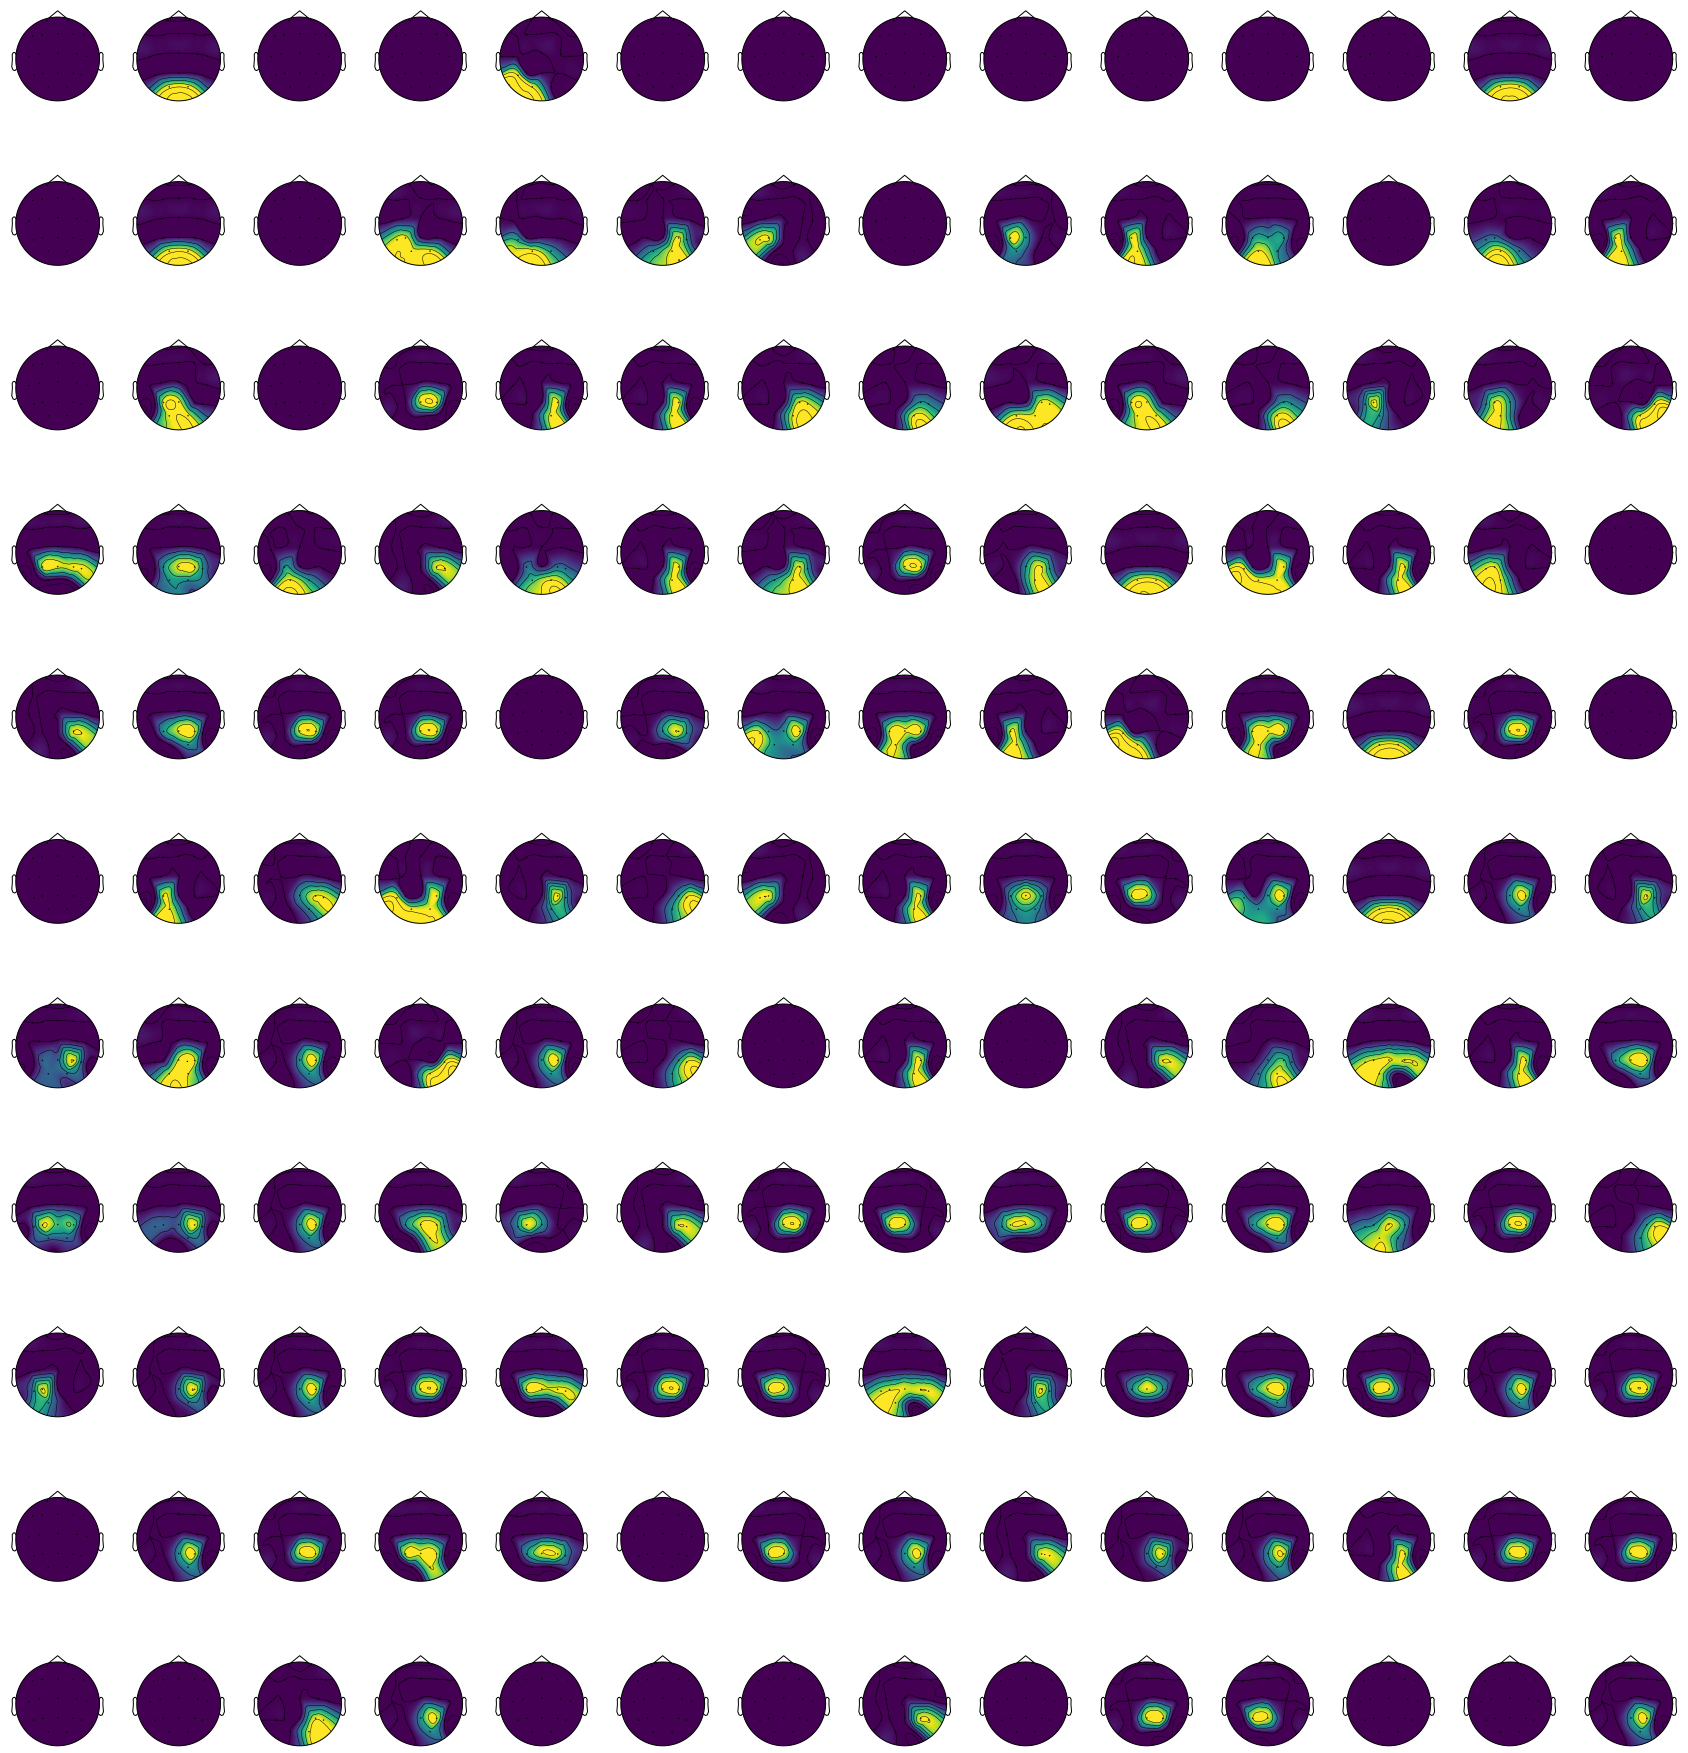

In [ ]:
for gr in range(1,2):
  plv = plv_gr[gr]
  plv_m = np.zeros((plv.shape[0],plv.shape[1],plv.shape[2],plv.shape[3]))
  for fre in range(plv.shape[2]):#Subjects:
    for t in range(len(windows)):
      for cx in range(plv.shape[1]):
        if sum(plv[:,cx,fre,t]>0) == len(Subjects):
          plv_m[:,cx,fre,t] = plv[:,cx,fre,t].dot(1)
        else:
          plv_m[:,cx,fre,t] = plv[:,cx,fre,t].dot(0)

  plv_ = np.squeeze(np.mean(plv_m,axis=0)) # plv es de sujetos,conexiones,frecuencias y tiempos.

  itr = 1
  fig=plt.figure(figsize=(30,30))
  for fre in range(len(bands)-1):#Subjects:
    for t in range(plv_.shape[2]):
      ax = fig.add_subplot(len(bands)-1,plv_.shape[2],itr)
      itr +=1
      mne.viz.plot_topomap(bct.strengths_und(squareform(plv_[:,fre,t])),
                          info, axes=ax, cmap='viridis', show=False, #sensors=True,
                          extrapolate='head', ch_type='eeg')
      

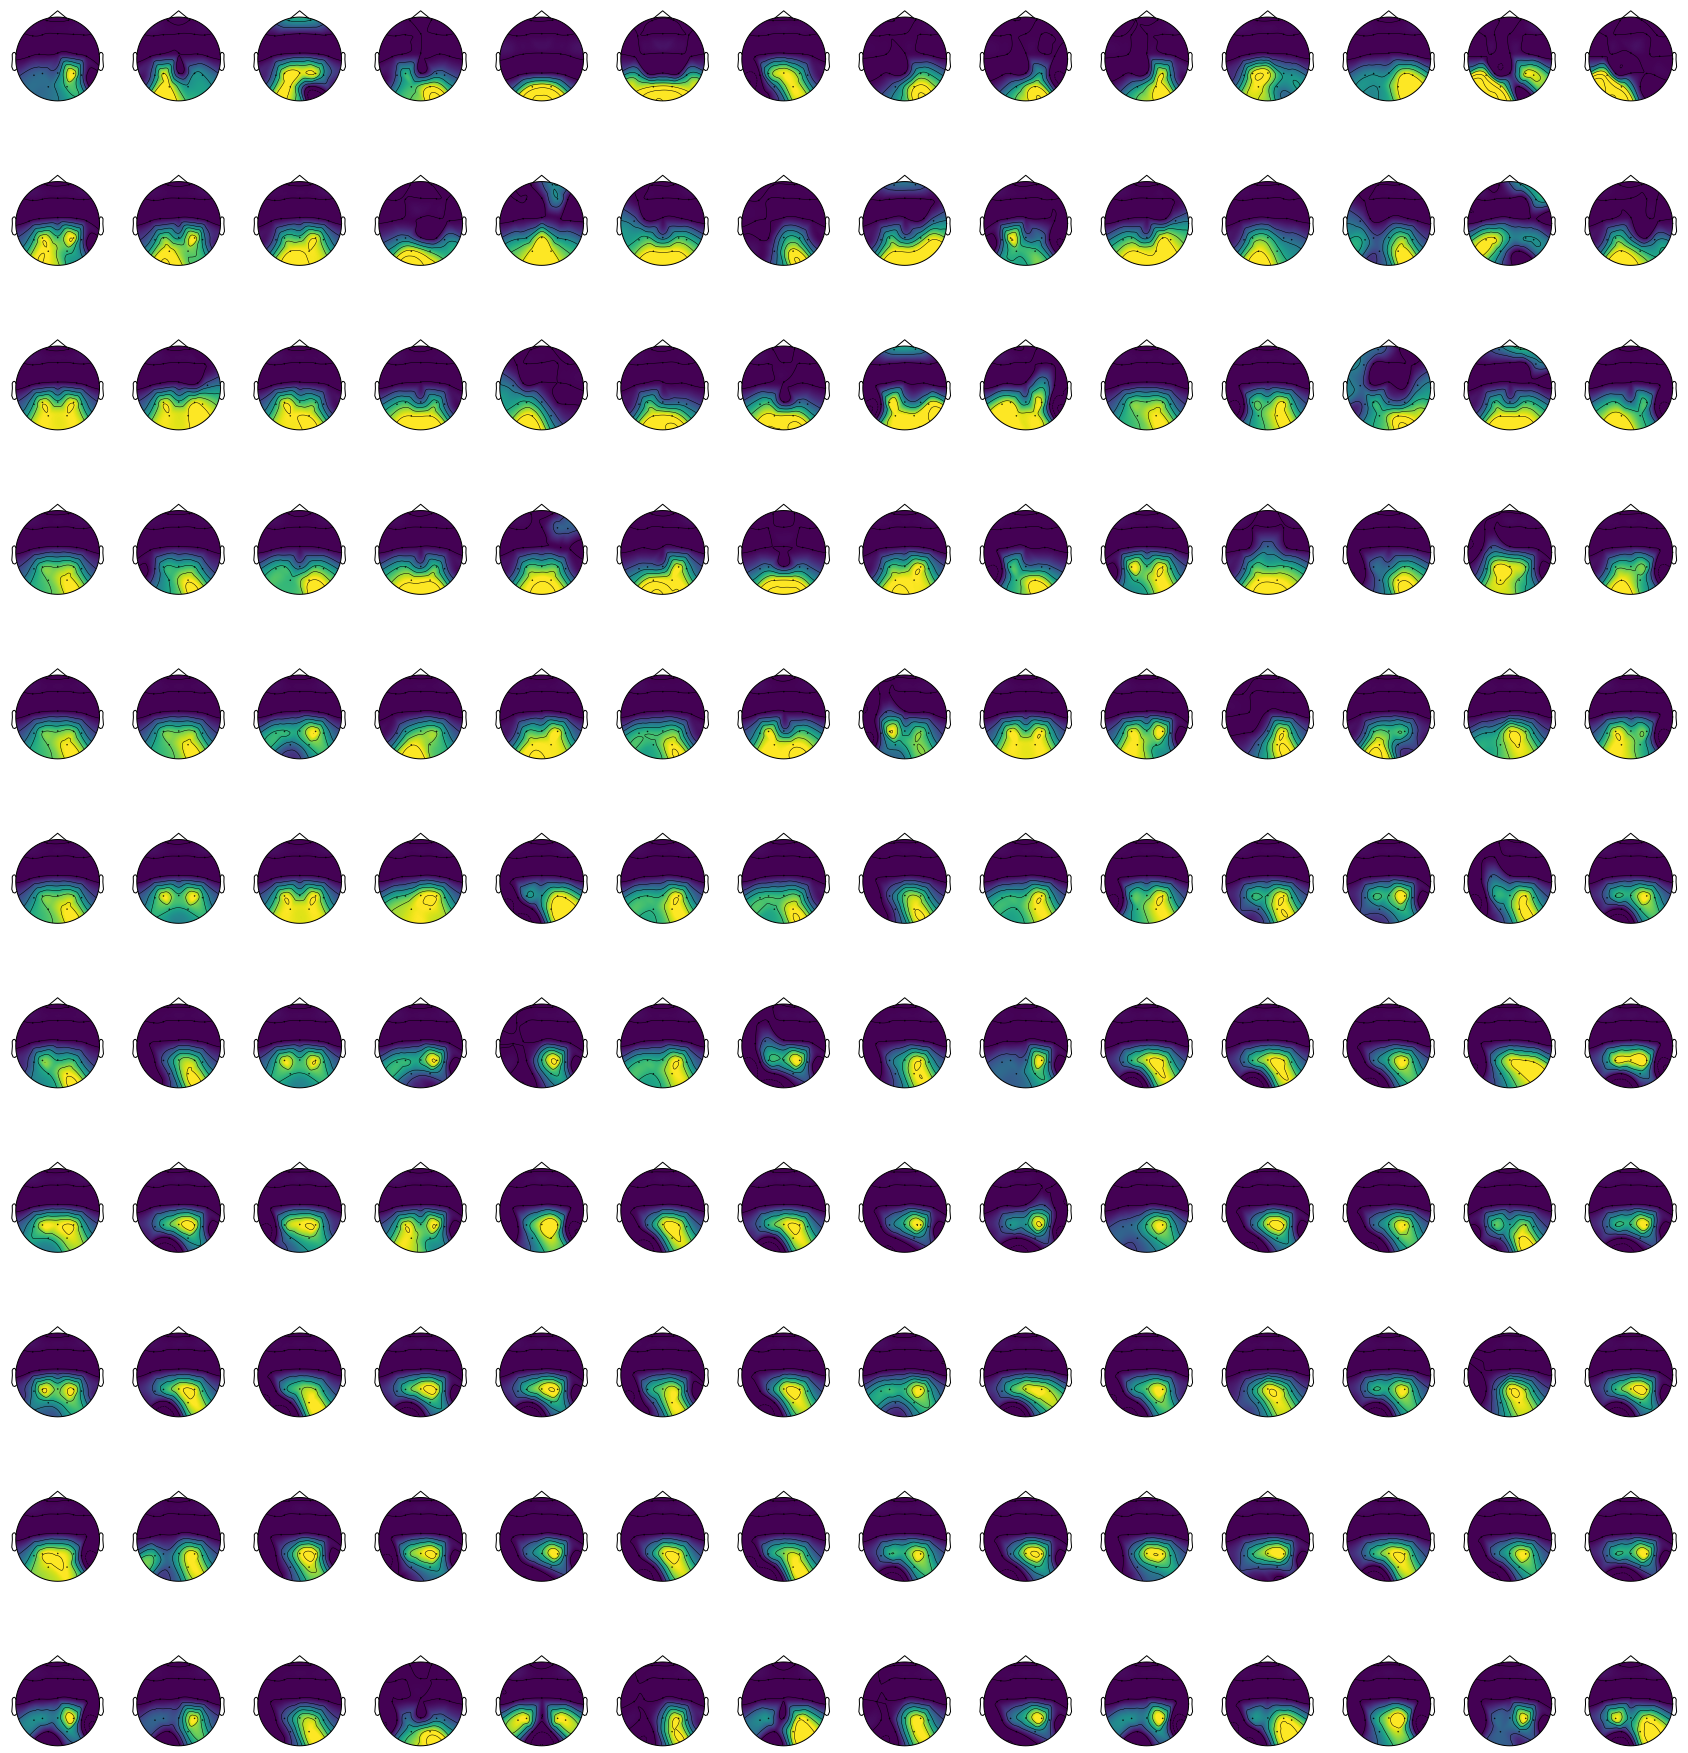

In [ ]:
for gr in range(2,3):
  plv = plv_gr[gr]
  plv_m = np.zeros((plv.shape[0],plv.shape[1],plv.shape[2],plv.shape[3]))
  for fre in range(plv.shape[2]):#Subjects:
    for t in range(len(windows)):
      for cx in range(plv.shape[1]):
        if sum(plv[:,cx,fre,t]>0) == len(Subjects):
          plv_m[:,cx,fre,t] = plv[:,cx,fre,t].dot(1)
        else:
          plv_m[:,cx,fre,t] = plv[:,cx,fre,t].dot(0)

  plv_ = np.squeeze(np.mean(plv_m,axis=0)) # plv es de sujetos,conexiones,frecuencias y tiempos.

  itr = 1
  fig=plt.figure(figsize=(30,30))
  for fre in range(len(bands)-1):#Subjects:
    for t in range(plv_.shape[2]):
      ax = fig.add_subplot(len(bands)-1,plv_.shape[2],itr)
      itr +=1
      mne.viz.plot_topomap(bct.strengths_und(squareform(plv_[:,fre,t])),
                          info, axes=ax, cmap='viridis', show=False, #sensors=True,
                          extrapolate='head', ch_type='eeg')
      

## OR

In [ ]:
for gr in range(1):
  plv = plv_gr[gr]
  plv_m = np.zeros((plv.shape[0],plv.shape[1],plv.shape[2],plv.shape[3]))
  for fre in range(plv.shape[2]):#Subjects:
    for t in range(len(windows)):
      for cx in range(plv.shape[1]):
        if sum(plv[:,cx,fre,t]>0)>0:
          plv_m[:,cx,fre,t] = plv[:,cx,fre,t].dot(1)
        else:
          plv_m[:,cx,fre,t] = plv[:,cx,fre,t].dot(0)

  plv_ = np.squeeze(np.mean(plv_m,axis=0)) # plv es de sujetos,conexiones,frecuencias y tiempos.

  itr = 1
  fig=plt.figure(figsize=(30,30))
  for fre in range(len(bands)-1):#Subjects:
    for t in range(plv_.shape[2]):
      ax = fig.add_subplot(len(bands)-1,plv_.shape[2],itr)
      itr +=1
      mne.viz.plot_topomap(bct.strengths_und(squareform(plv_[:,fre,t])),
                          info, axes=ax, cmap='viridis', show=False, #sensors=True,
                          extrapolate='head', ch_type='eeg')
      

Output hidden; open in https://colab.research.google.com to view.

# caracteristicas de pitch

In [ ]:
pos_t2 = np.concatenate(np.asarray(list(y_km_f_3)).reshape(-1,1)[esti[0,:].astype(bool)])
for gr in range(3):
  for sub in Subjects:
    con, freqs, times, n_epochs, n_tapers = connectivity(data_ref[sub-1][pos_t2==gr,:,:],
                                                         method='plv',  mode='cwt_morlet', sfreq=sampling_freq,
                                                         cwt_freqs=cwt_freqs, 
                                                         cwt_n_cycles=cwt_n_cycles, n_jobs=1,
                                                         verbose = 10)
    plv = np.zeros((v,freqs.shape[0],times.shape[0]))
    for fr in range(freqs.shape[0]):
      for t in range(times.shape[0]):
        plv[:,fr,t]= squareform(con[:,:,fr,t]+con[:,:,fr,t].T)
    del con
    savemat(load_path+f'conectividad_plv_f_s'+str(sub)+'_gr'+str(gr+1)+'.mat',{'PLV':plv,'freqs':freqs,'times':times,'n_epochs':n_epochs})

Connectivity computation...
only using indices for lower-triangular matrix
    computing connectivity for 171 connections
    using t=0.000s..15.000s for estimation (15001 points)
    frequencies: 2.0Hz..46.0Hz (23 points)
    using CWT with Morlet wavelets to estimate spectra
    the following metrics will be computed: PLV
    computing connectivity for epoch 1
    computing connectivity for epoch 2
    computing connectivity for epoch 3
    computing connectivity for epoch 4
    computing connectivity for epoch 5
    computing connectivity for epoch 6
    computing connectivity for epoch 7
    computing connectivity for epoch 8
    computing connectivity for epoch 9
    computing connectivity for epoch 10
    computing connectivity for epoch 11
    computing connectivity for epoch 12
    computing connectivity for epoch 13
    computing connectivity for epoch 14
    computing connectivity for epoch 15
    computing connectivity for epoch 16
    computing connectivity for epoch 17
   

In [ ]:
umbral = 0.3
# Sujetos de la base de datos
Subjects = list(np.arange(1,32))
# canales de la base de datos
channels = ['Fp1', 'Fp2', 'F7', 'F3', 'Fz', 'F4', 'F8', 'T3', 'C3', 'Cz', 'C4',
            'T4', 'T5', 'P3', 'Pz', 'P4', 'T6', 'O1', 'O2']
n_channels = len(channels)
v = int((n_channels*(n_channels-1))/2)
# Frecuencia de muestreo de la base de datos.
sampling_freq  = 1000
# ubicación de la base de datos.
load_path = '/content/drive/Shareddrives/GCPDS/databases/Databases_musica/Affective music listening 2/'

window  = 1*sampling_freq # 3,   3   segundo de la ventana.
step    = window*1      # 50%, 80% de traslape.
windows = list(np.arange(0,15*sampling_freq-window,step))
bands   = [2]
bands.extend(list(freqs[0,1::2].astype(int)))


plv_gr  = list()
for gr in range(3):
  plv   = np.zeros((len(Subjects),v,len(bands)-1,len(windows)))
  for sub in Subjects:
    print('Sujeto'+str(sub))
    data = loadmat(load_path+f'conectividad_plv_s'+str(sub)+'_gr'+str(gr+1)+'.mat')
    con_ = data['PLV']
    con = np.zeros((con_.shape[0],len(bands),con_.shape[2]))
    
    for fr in range(len(bands)-1):
      if fr == 0:
        fr1,fr2 = fr,fr+1
      else: 
        fr1,fr2 = list(freqs[0,:]).index(bands[fr]),list(freqs[0,:]).index(bands[fr+1])
      con[:,fr,:] = np.mean(con_[:,fr1:fr2,:],axis=1)
      
    freqs = data['freqs']
    times = data['times']
    for fr in range(len(bands)-1):
      for t in range(len(windows)):
        plv[sub-1,:,fr,t] = squareform(bct.threshold_proportional(squareform((np.squeeze(con[:,fr,int(windows[t])]))),umbral))
    del con
  plv_gr.append(plv)


# conectividad agrupación por energía 

In [ ]:
pos_t2 = np.concatenate(np.asarray(list(y_km_e_3)).reshape(-1,1)[esti[0,:].astype(bool)])
for gr in range(3):
  for sub in Subjects:
    con, freqs, times, n_epochs, n_tapers = connectivity(data_ref[sub-1][pos_t2==gr,:,:],
                                                         method='plv',  mode='cwt_morlet', sfreq=sampling_freq,
                                                         cwt_freqs=cwt_freqs, 
                                                         cwt_n_cycles=cwt_n_cycles, n_jobs=1,
                                                         verbose = 10)
    plv = np.zeros((v,freqs.shape[0],times.shape[0]))
    for fr in range(freqs.shape[0]):
      for t in range(times.shape[0]):
        plv[:,fr,t]= squareform(con[:,:,fr,t]+con[:,:,fr,t].T)
    del con
    savemat(load_path+f'conectividad_plv_e_s'+str(sub)+'_gr'+str(gr+1)+'.mat',{'PLV':plv,'freqs':freqs,'times':times,'n_epochs':n_epochs})

Connectivity computation...
only using indices for lower-triangular matrix
    computing connectivity for 171 connections
    using t=0.000s..15.000s for estimation (15001 points)
    frequencies: 2.0Hz..46.0Hz (23 points)
    using CWT with Morlet wavelets to estimate spectra
    the following metrics will be computed: PLV
    computing connectivity for epoch 1
    computing connectivity for epoch 2
    computing connectivity for epoch 3
    computing connectivity for epoch 4
    computing connectivity for epoch 5
    computing connectivity for epoch 6
    computing connectivity for epoch 7
    assembling connectivity matrix
[Connectivity computation done]
Connectivity computation...
only using indices for lower-triangular matrix
    computing connectivity for 171 connections
    using t=0.000s..15.000s for estimation (15001 points)
    frequencies: 2.0Hz..46.0Hz (23 points)
    using CWT with Morlet wavelets to estimate spectra
    the following metrics will be computed: PLV
    comp

In [ ]:
umbral = 0.3
# Sujetos de la base de datos
Subjects = list(np.arange(1,32))
# canales de la base de datos
channels = ['Fp1', 'Fp2', 'F7', 'F3', 'Fz', 'F4', 'F8', 'T3', 'C3', 'Cz', 'C4',
            'T4', 'T5', 'P3', 'Pz', 'P4', 'T6', 'O1', 'O2']
n_channels = len(channels)
v = int((n_channels*(n_channels-1))/2)
# Frecuencia de muestreo de la base de datos.
sampling_freq  = 1000
# ubicación de la base de datos.
load_path = '/content/drive/Shareddrives/GCPDS/databases/Databases_musica/Affective music listening 2/'

window  = 1*sampling_freq # 3,   3   segundo de la ventana.
step    = window*1      # 50%, 80% de traslape.
windows = list(np.arange(0,15*sampling_freq-window,step))
bands   = [2]
bands.extend(list(freqs[0,1::2].astype(int)))


plv_gr  = list()
for gr in range(3):
  plv   = np.zeros((len(Subjects),v,len(bands)-1,len(windows)))
  for sub in Subjects:
    print('Sujeto'+str(sub))
    data = loadmat(load_path+f'conectividad_plv_e_s'+str(sub)+'_gr'+str(gr+1)+'.mat')
    con_ = data['PLV']
    con = np.zeros((con_.shape[0],len(bands),con_.shape[2]))
    
    for fr in range(len(bands)-1):
      if fr == 0:
        fr1,fr2 = fr,fr+1
      else: 
        fr1,fr2 = list(freqs[0,:]).index(bands[fr]),list(freqs[0,:]).index(bands[fr+1])
      con[:,fr,:] = np.mean(con_[:,fr1:fr2,:],axis=1)
      
    freqs = data['freqs']
    times = data['times']
    for fr in range(len(bands)-1):
      for t in range(len(windows)):
        plv[sub-1,:,fr,t] = squareform(bct.threshold_proportional(squareform((np.squeeze(con[:,fr,int(windows[t])]))),umbral))
    del con
  plv_gr.append(plv)


Sujeto1
Sujeto2
Sujeto3
Sujeto4
Sujeto5
Sujeto6
Sujeto7
Sujeto8
Sujeto9
Sujeto10
Sujeto11
Sujeto12
Sujeto13
Sujeto14
Sujeto15
Sujeto16
Sujeto17
Sujeto18
Sujeto19
Sujeto20
Sujeto21
Sujeto22
Sujeto23
Sujeto24
Sujeto25
Sujeto26
Sujeto27
Sujeto28
Sujeto29
Sujeto30
Sujeto31
Sujeto1
Sujeto2
Sujeto3
Sujeto4
Sujeto5
Sujeto6
Sujeto7
Sujeto8
Sujeto9
Sujeto10
Sujeto11
Sujeto12
Sujeto13
Sujeto14
Sujeto15
Sujeto16
Sujeto17
Sujeto18
Sujeto19
Sujeto20
Sujeto21
Sujeto22
Sujeto23
Sujeto24
Sujeto25
Sujeto26
Sujeto27
Sujeto28
Sujeto29
Sujeto30
Sujeto31
Sujeto1
Sujeto2
Sujeto3
Sujeto4
Sujeto5
Sujeto6
Sujeto7
Sujeto8
Sujeto9
Sujeto10
Sujeto11
Sujeto12
Sujeto13
Sujeto14
Sujeto15
Sujeto16
Sujeto17
Sujeto18
Sujeto19
Sujeto20
Sujeto21
Sujeto22
Sujeto23
Sujeto24
Sujeto25
Sujeto26
Sujeto27
Sujeto28
Sujeto29
Sujeto30
Sujeto31


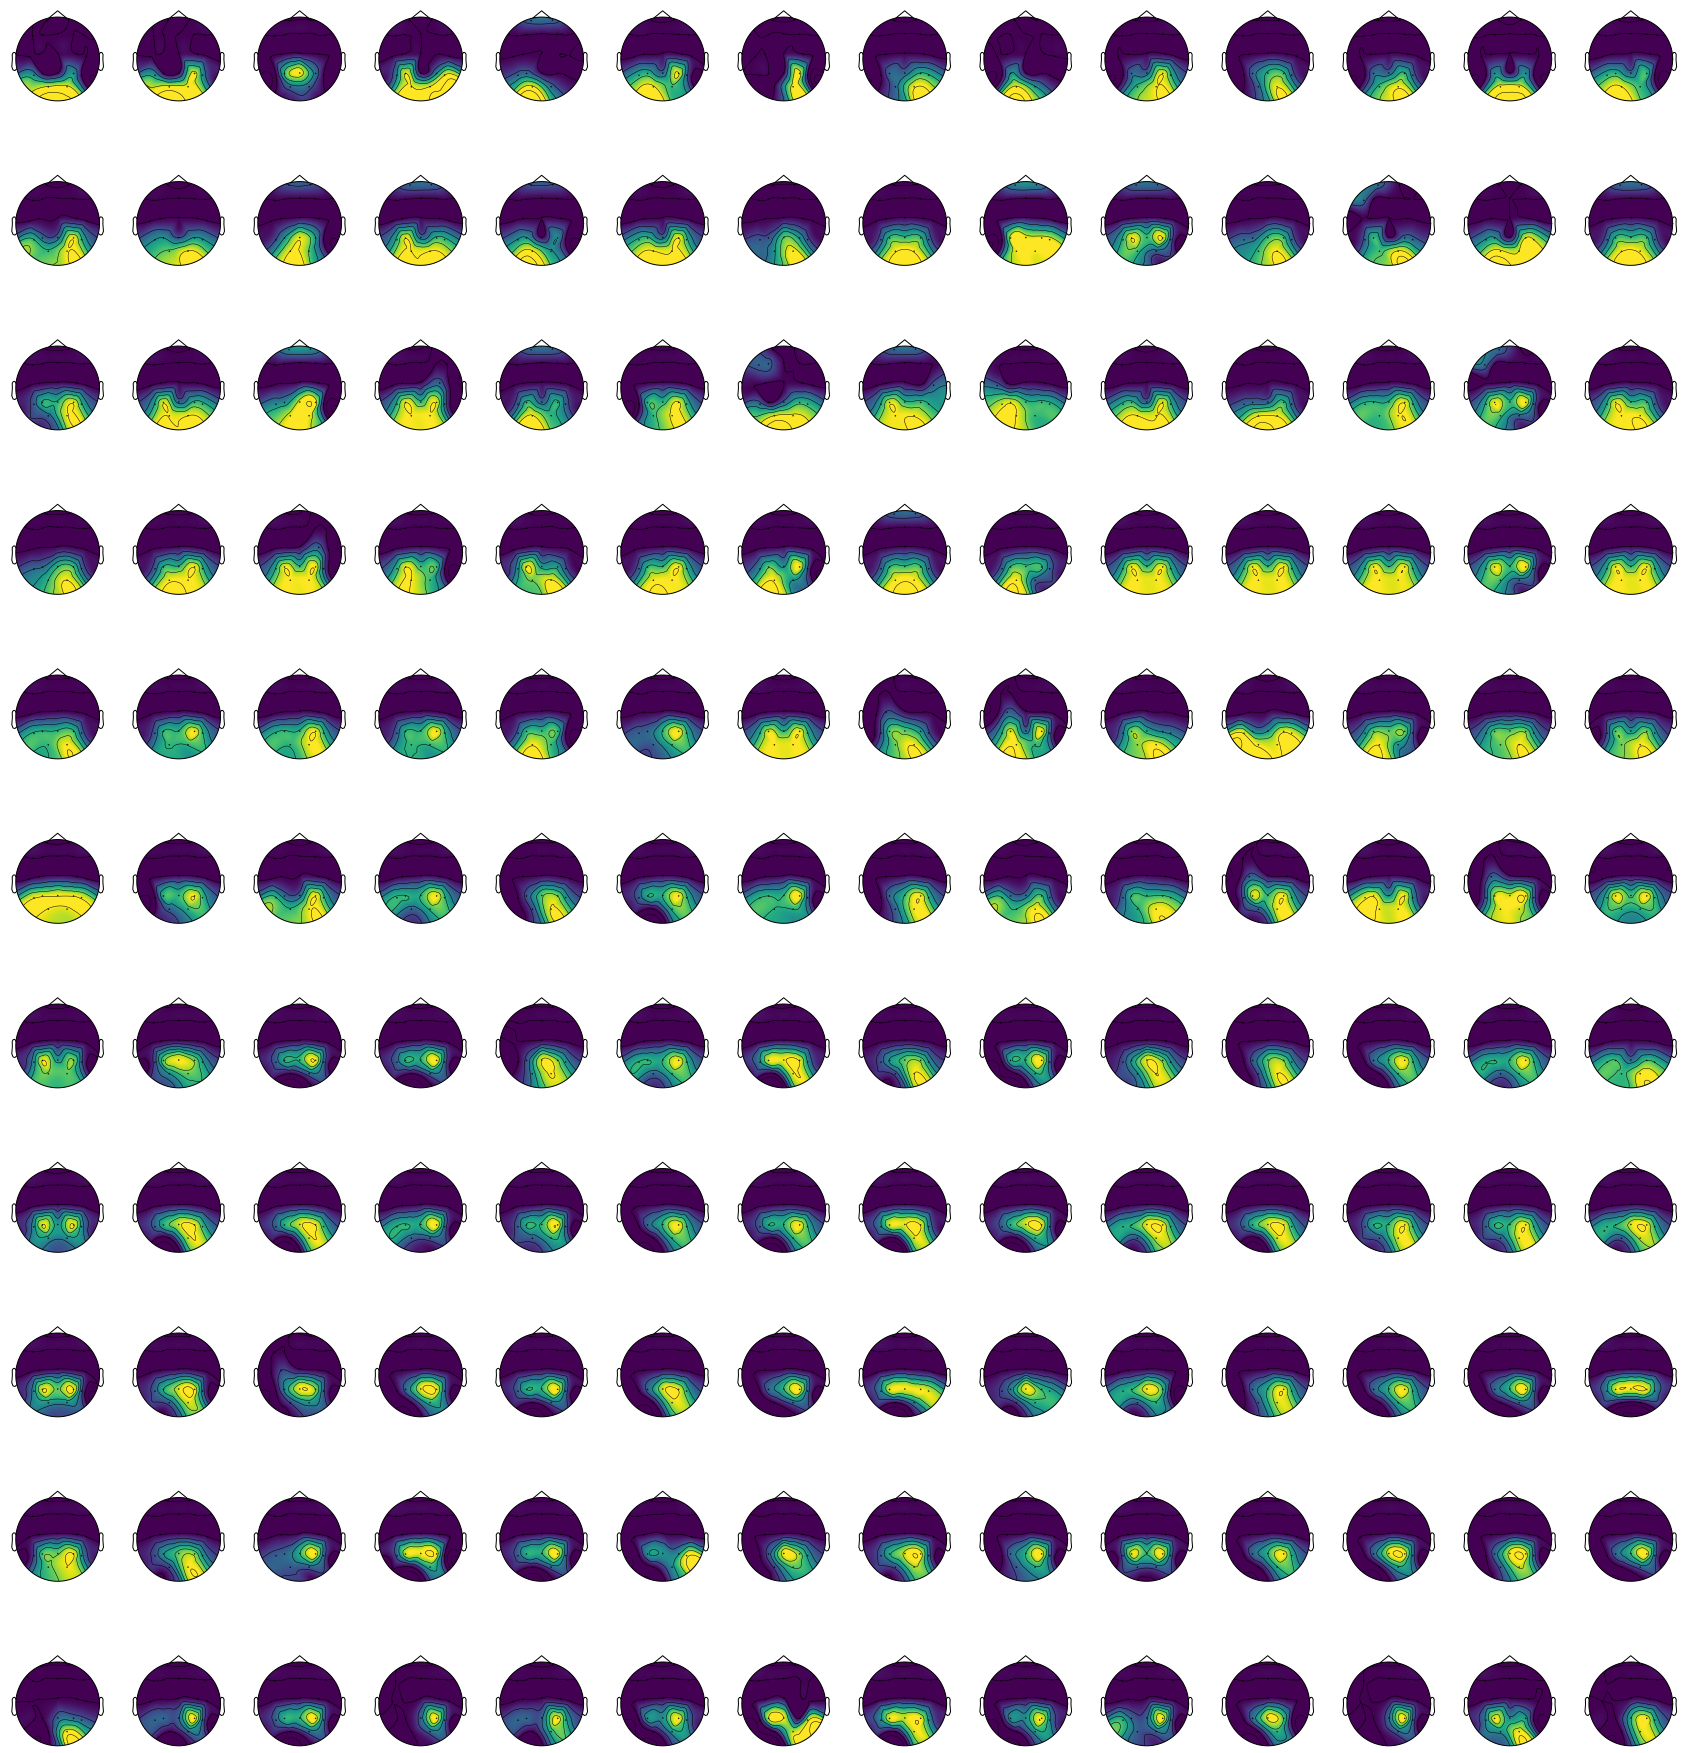

In [ ]:
for gr in range(2,3):
  plv = plv_gr[gr]
  plv_m = np.zeros((plv.shape[0],plv.shape[1],plv.shape[2],plv.shape[3]))
  for fre in range(plv.shape[2]):#Subjects:
    for t in range(len(windows)):
      for cx in range(plv.shape[1]):
        if sum(plv[:,cx,fre,t]>0) == len(Subjects):
          plv_m[:,cx,fre,t] = plv[:,cx,fre,t].dot(1)
        else:
          plv_m[:,cx,fre,t] = plv[:,cx,fre,t].dot(0)

  plv_ = np.squeeze(np.mean(plv_m,axis=0)) # plv es de sujetos,conexiones,frecuencias y tiempos.

  itr = 1
  fig=plt.figure(figsize=(30,30))
  for fre in range(len(bands)-1):#Subjects:
    for t in range(plv_.shape[2]):
      ax = fig.add_subplot(len(bands)-1,plv_.shape[2],itr)
      itr +=1
      mne.viz.plot_topomap(bct.strengths_und(squareform(plv_[:,fre,t])),
                          info, axes=ax, cmap='viridis', show=False, #sensors=True,
                          extrapolate='head', ch_type='eeg')
      